# Meridien Deep Dive Notebook

This notebook applies the helper toolkit to the Hotel Brands individual-level export to isolate how Le Meridien performs relative to the rest of the competitive set. Each section mixes code, helper-driven visuals, and narrative notes so you can keep iterating with a clear mental model.

**Data snapshot**
- Source: `data/Hotel Brands_raw_data_indiv_lvl.csv` with placeholder nulls `['#NULL!', 'NULL']` replaced by true `NaN` values.
- Shape: 385 rows × 441 columns with 72,100 missing cells across 433 columns.
- Heaviest missing columns: Q24_5_TEXT: 378, SCRmerid: 366, Meridienpf: 366, Dolcepf: 365, Indigopf: 365.


In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

from helper import (
    count_nulls,
    ajr_plot_histograms,
    ajr_plot_correlations,
    ajr_correlation_heatmap,
)

plt.style.use('seaborn-v0_8-whitegrid')
pd.options.display.float_format = '{:,.2f}'.format


## Loading and sanity checks
We read the CSV once and reuse the dataframe across sections. The preview below confirms the Qualtrics metadata (timestamps, status) plus hundreds of brand attribute grids.


In [2]:
DATA_PATH = Path('data/Hotel Brands_raw_data_indiv_lvl.csv')
NA_VALUES = ['#NULL!','NULL']

df = pd.read_csv(DATA_PATH, na_values=NA_VALUES)
print(f"Loaded {df.shape[0]:,} rows and {df.shape[1]:,} columns")
df.head()


Loaded 385 rows and 441 columns


,StartDate,EndDate,Status,Progress,Duration__in_seconds_,Finished,RecordedDate,ResponseId,Q_RecaptchaScore,totalnights,...,SCRascend,SCRmerid,SCRsher,SCRwestin,SCRwynd,SCRdolce,SCRmarriott,SCRhyatt,SCRhilt,SCRemb
0,1/16/20 22:16,1/16/20 22:20,0,100.00,237.00,1,1/16/20 22:20,R_1qUS7Sta2jPMOi1,0.90,NaN,...,0.06,0.04,0.01,0.03,0.01,0.03,0.03,0.03,0.04,0.03
1,1/15/20 18:11,1/15/20 18:12,0,19.00,95.00,0,1/17/20 18:12,R_1CfgGpDe1JJWaeY,0.90,100.00,...,NaN,NaN,0.34,NaN,NaN,NaN,NaN,NaN,0.34,NaN
2,1/15/20 22:03,1/15/20 22:22,0,100.00,"1,109.00",1,1/15/20 22:22,R_2cbmKnt8yU6NtWB,0.10,228.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.06
3,1/16/20 0:49,1/16/20 1:13,0,100.00,"1,489.00",1,1/16/20 1:13,R_3KO67z2x3hBoVQj,0.90,168.00,...,NaN,NaN,0.12,0.12,NaN,NaN,0.03,0.12,0.18,0.12
4,1/15/20 17:51,1/15/20 17:55,0,24.00,231.00,0,1/17/20 17:55,R_0VNtuuOPIzqy2M9,0.90,80.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.33,0.33


## Missingness overview
`count_nulls` ranks the columns with the highest null volumes so we know what to ignore or backfill. SCR Meridien and the preference/penalty fields are among the sparsest, so later sections always report their sample sizes explicitly.


In [3]:
null_summary = count_nulls(df)
null_summary.head(15)


,nulls,percent_missing
Q24_5_TEXT,378,0.98
Meridienpf,366,0.95
SCRmerid,366,0.95
SCRdolce,365,0.95
Indigopf,365,0.95
Dolcepf,365,0.95
SCRindigo,365,0.95
SCRascend,364,0.95
Ascendpf,364,0.95
SCRmain,362,0.94


## Trip mix context
The summary stats (median total nights 8 vs. business 2 and leisure 6) show leisure dominates most respondent travel, but the max of 228 nights flags a heavy right tail. Keeping those outliers in mind matters when we look at per-brand engagement below.


In [4]:
trip_cols = ['totalnights','busnights','leisnights']
trip_summary = df[trip_cols].describe().T
trip_summary


,count,mean,std,min,25%,50%,75%,max
totalnights,384.00,12.35,17.83,0.00,4.75,8.00,14.25,228.00
busnights,372.00,4.96,15.29,0.00,0.00,2.00,5.00,218.00
leisnights,384.00,7.55,8.50,0.00,3.00,6.00,10.00,100.00


## 1. Meridien engagement footprint
- Median respondent logs 1 Meridien stays (max 5), so most people recorded a single recent visit.
- Marriott averages 1.85 stays per respondent, indicating that Meridien loyalists are typically heavier Marriott-system users overall.
- Co-stay correlations: Westin (0.51) and Hyatt (0.41) move most closely with Meridien, hinting that guests bucket Meridien alongside other premium/lifestyle brands.
- The co-stay mean table for Meridien guests (Meridien nights > 0) further shows their next-most-common brands: Hiltonnights: 1.85, Marriottnights: 1.82, Courtyardnights: 1.52, Hyattnights: 1.46, Sheratonnights: 1.33, Westinnights: 1.30, Wyndhamnights: 1.29.


,count,mean,std,min,25%,50%,75%,max
Meridiennights,361.00,1.12,0.55,1.00,1.00,1.00,1.00,5.00
Hyattnights,363.00,1.47,0.91,1.00,1.00,1.00,2.00,5.00
Hiltonnights,362.00,1.86,1.20,1.00,1.00,1.00,2.00,5.00
Westinnights,360.00,1.31,0.84,1.00,1.00,1.00,1.00,5.00
Marriottnights,369.00,1.85,1.12,1.00,1.00,1.00,2.00,5.00
Sheratonnights,361.00,1.34,0.82,1.00,1.00,1.00,1.00,5.00


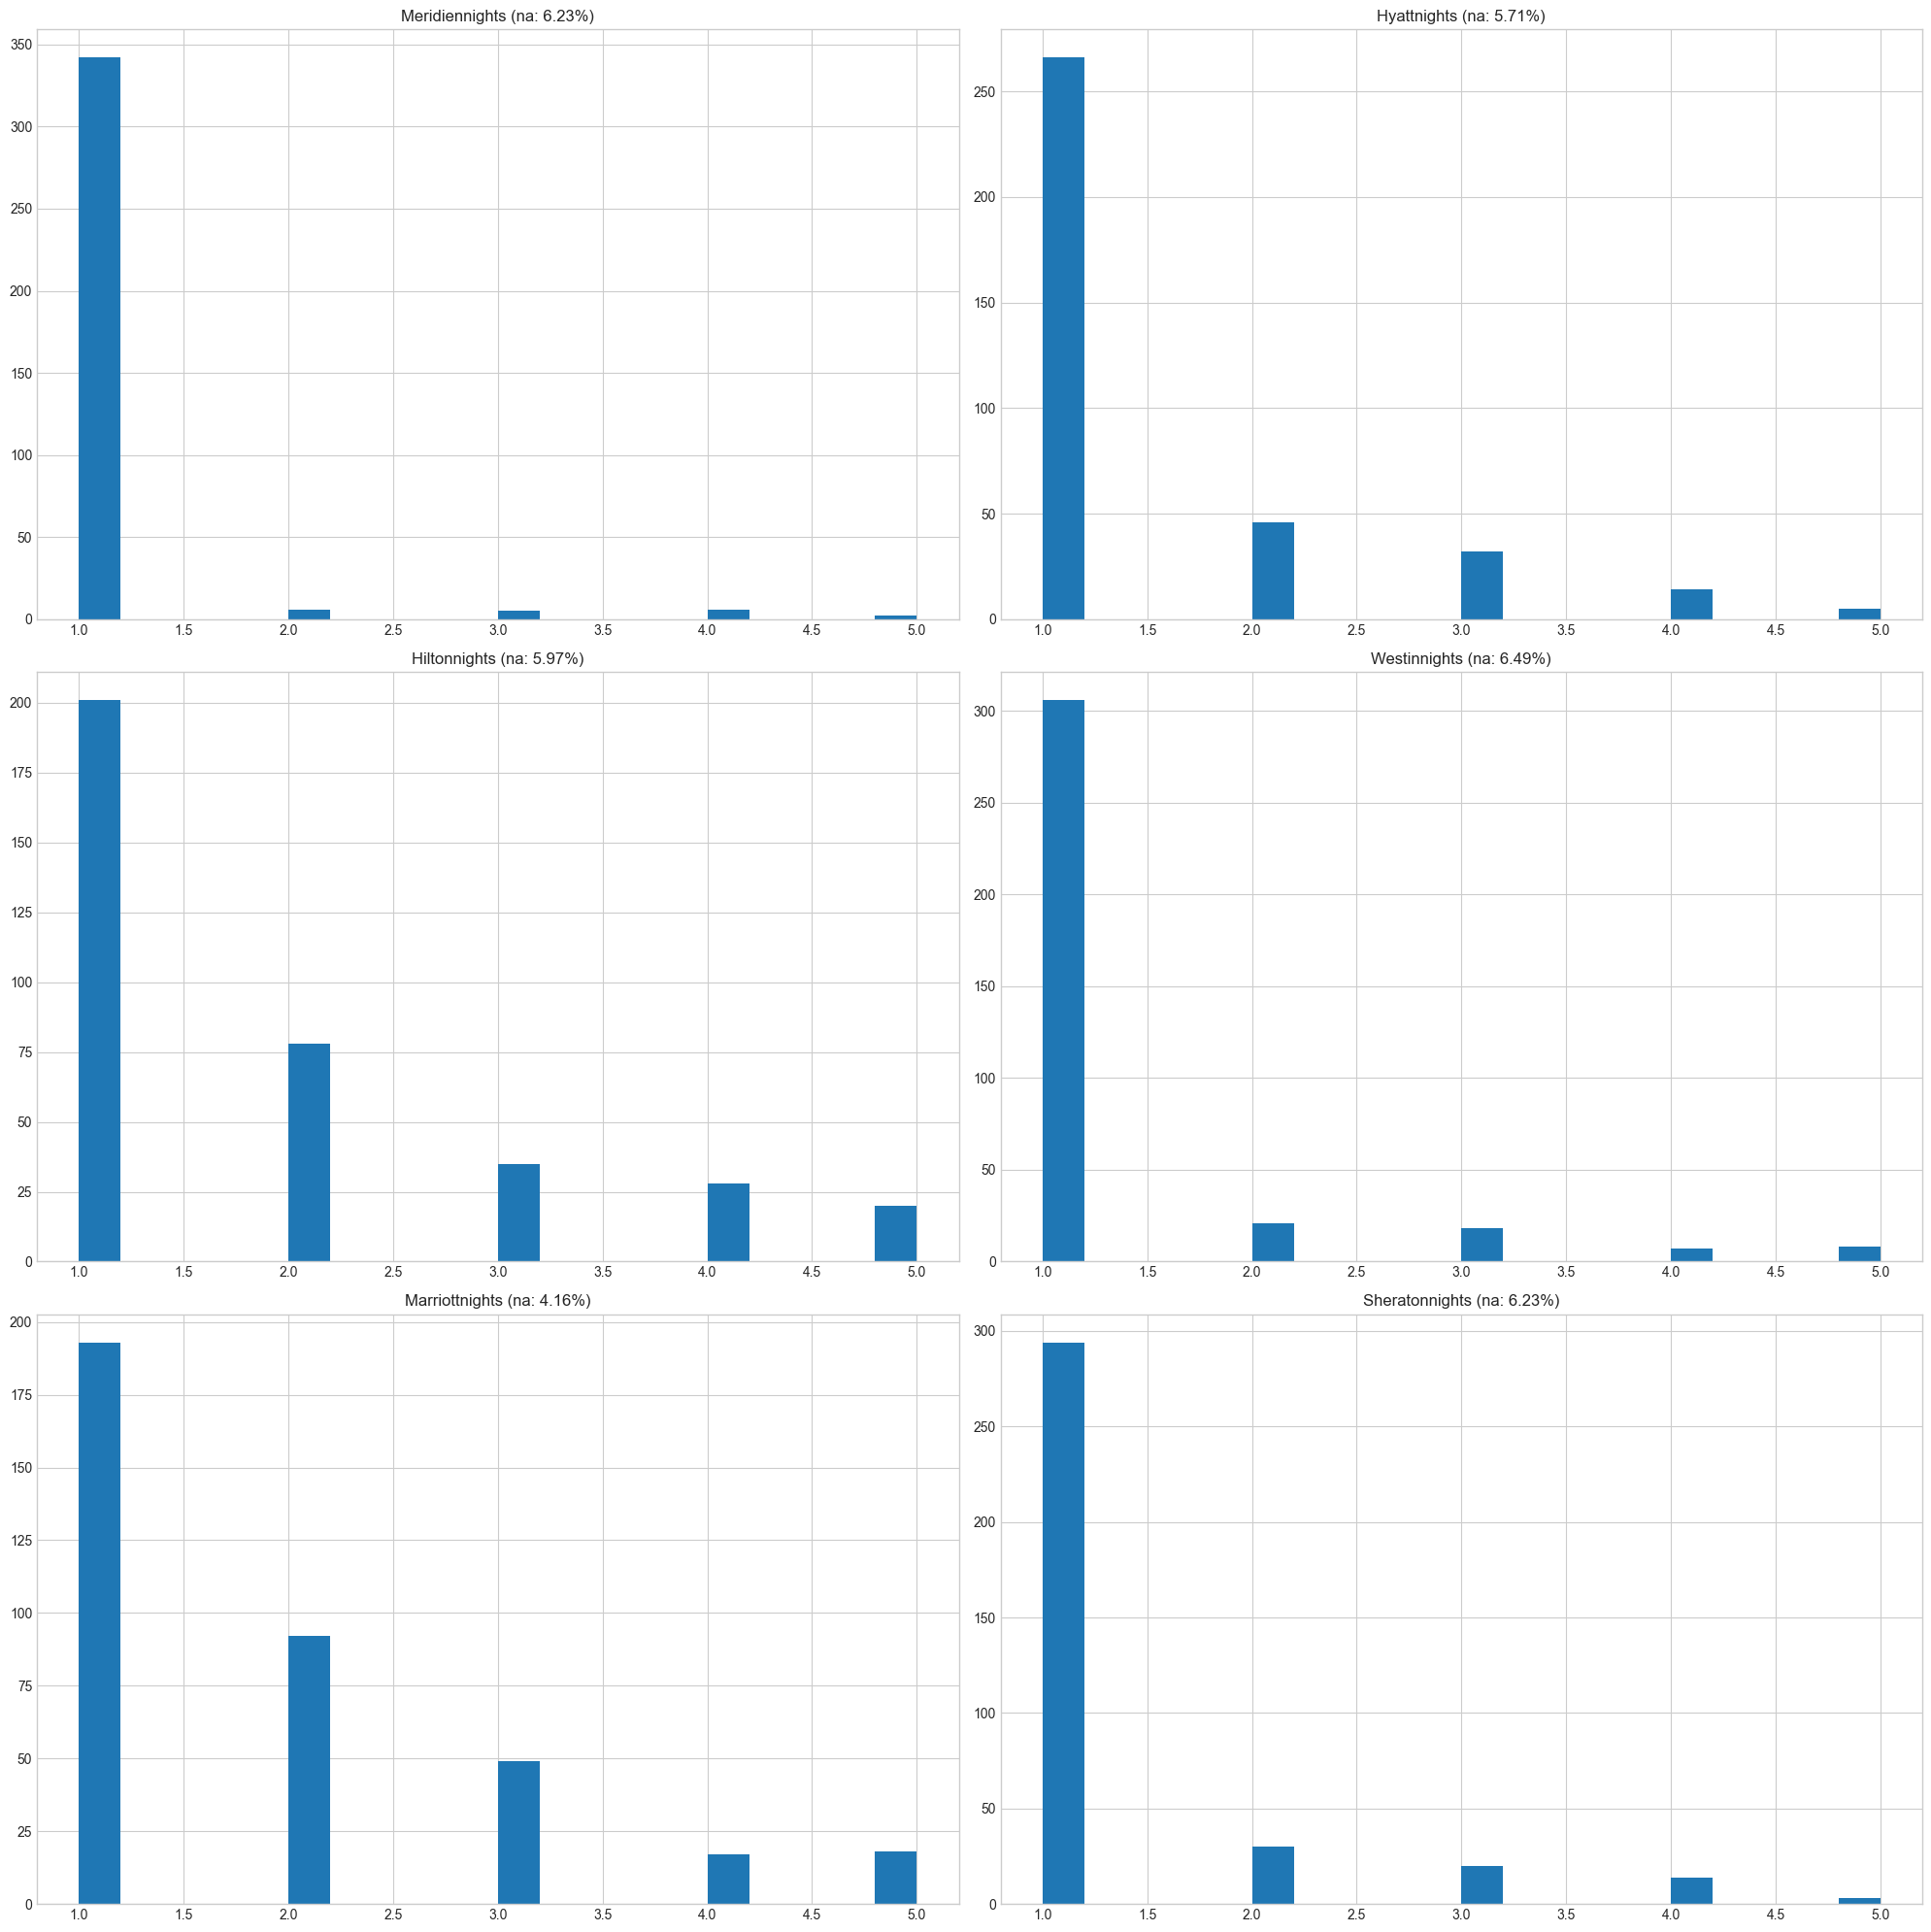

Meridiennights   1.00
Westinnights     0.51
Hyattnights      0.41
Sheratonnights   0.33
Hiltonnights     0.22
Marriottnights   0.20
Name: Meridiennights, dtype: float64

In [5]:
nights_cols = ['Meridiennights','Hyattnights','Hiltonnights','Westinnights','Marriottnights','Sheratonnights']
nights_summary = df[nights_cols].describe().T
display(nights_summary)

ajr_plot_histograms(df[nights_cols])

co_stay = df[nights_cols].corr()
co_stay['Meridiennights'].sort_values(ascending=False)


In [6]:
mer_sample = df[df['Meridiennights'] > 0]
compare_cols = ['Hyattnights','Hiltonnights','Westinnights','Marriottnights','Sheratonnights','Wyndhamnights','Courtyardnights']
co_mean = mer_sample[compare_cols].mean().sort_values(ascending=False)
co_mean


Hiltonnights      1.85
Marriottnights    1.82
Courtyardnights   1.52
Hyattnights       1.46
Sheratonnights    1.33
Westinnights      1.30
Wyndhamnights     1.29
dtype: float64

## 2. Attitudinal stack driving SCR
Only 13 respondents answered the full Meridien attitudinal battery and `SCRmerid`, so interpretations should stay directional. Within that set we see the tightest relationships across: SCRmerid: 1.00, wellMerid: 0.55, safeMeridien: 0.52, clMerid: 0.39, Meridiennights: 0.37. Note how experiential warmth (`wellMerid`) outperforms functional statements (`sucMeridien`) in predicting SCR.


In [7]:
mer_cols = ['Meridiennights','safeMeridien','sucMeridien','specMeridien','cfreeMerid','wellMerid','clMerid','wmMerid','pamMerid','Meridienpen','Meridienpf','SCRmerid']
mer_stack = df[mer_cols].dropna()
print(f"Complete Meridien records: {len(mer_stack)}")
mer_stack.describe().T


Complete Meridien records: 13


,count,mean,std,min,25%,50%,75%,max
Meridiennights,13.00,3.38,1.04,2.00,3.00,3.00,4.00,5.00
safeMeridien,13.00,5.15,0.69,4.00,5.00,5.00,6.00,6.00
sucMeridien,13.00,4.46,1.56,2.00,4.00,5.00,6.00,6.00
specMeridien,13.00,4.46,1.33,1.00,4.00,5.00,5.00,6.00
cfreeMerid,13.00,4.69,1.49,2.00,4.00,5.00,6.00,6.00
wellMerid,13.00,4.69,1.55,1.00,4.00,5.00,6.00,6.00
clMerid,13.00,4.85,1.41,1.00,4.00,5.00,6.00,6.00
wmMerid,13.00,4.54,1.56,1.00,4.00,5.00,6.00,6.00
pamMerid,13.00,5.00,0.91,3.00,5.00,5.00,6.00,6.00
Meridienpen,13.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00


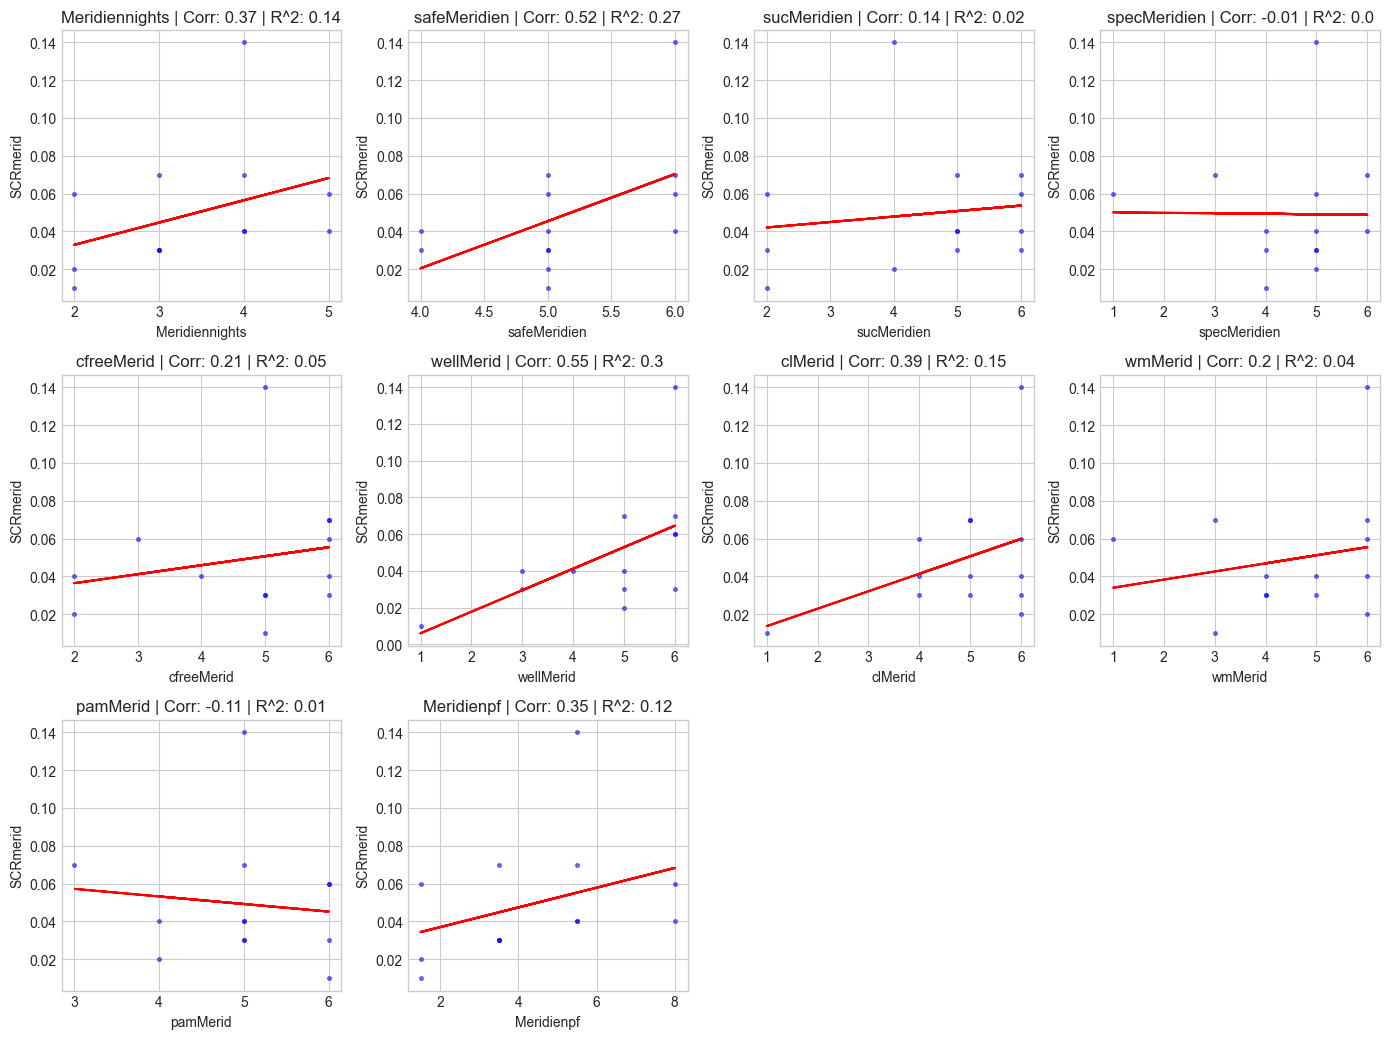

In [8]:
ajr_plot_correlations(mer_stack.drop(columns=['Meridienpen']), 'SCRmerid', fig_height=14, r_squared=True)


/Users/alexj/code/meridian/helper.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


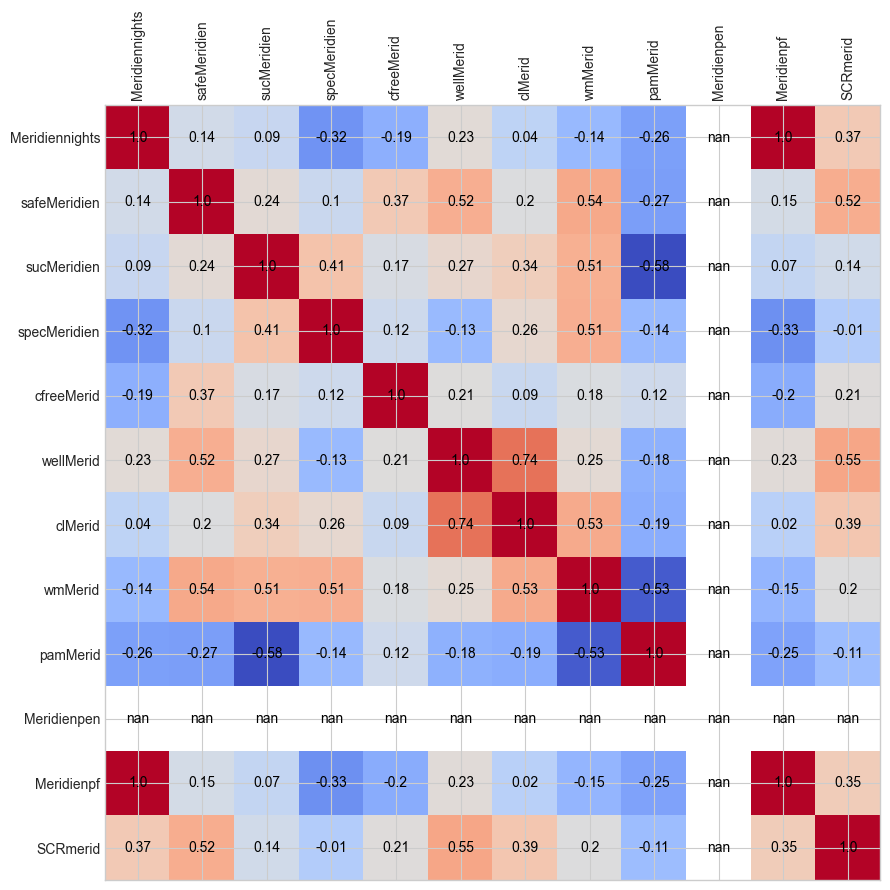

SCRmerid          1.00
wellMerid         0.55
safeMeridien      0.52
clMerid           0.39
Meridiennights    0.37
Meridienpf        0.35
cfreeMerid        0.21
wmMerid           0.20
sucMeridien       0.14
specMeridien     -0.01
pamMerid         -0.11
Meridienpen        NaN
Name: SCRmerid, dtype: float64

In [9]:
mer_corr = mer_stack.corr(numeric_only=True)
ajr_correlation_heatmap(mer_corr, fig_height=10)
mer_corr['SCRmerid'].sort_values(ascending=False)


## 3. Relative SCR positioning
Average SCRs across the comparison set come in as: SCRhilt: 0.29, SCRmarriott: 0.26, SCRhyatt: 0.22, SCRsher: 0.18, SCRwestin: 0.14, SCRmerid: 0.05. Meridien's mean of 0.047 over 19 records places it well below the broader premium set, so we focus on how frequently respondents even reach the SCR question and how that score shifts alongside attribute perceptions.


,count,mean,std,min,25%,50%,75%,max
SCRmerid,19.00,0.05,0.03,0.01,0.03,0.04,0.06,0.14
SCRhyatt,97.00,0.22,0.21,0.02,0.07,0.15,0.30,1.00
SCRhilt,161.00,0.29,0.25,0.01,0.11,0.20,0.35,1.00
SCRwestin,54.00,0.14,0.17,0.01,0.04,0.10,0.16,1.00
SCRmarriott,176.00,0.26,0.22,0.01,0.12,0.20,0.34,1.00
SCRsher,67.00,0.18,0.21,0.01,0.06,0.11,0.22,1.00


/Users/alexj/code/meridian/helper.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


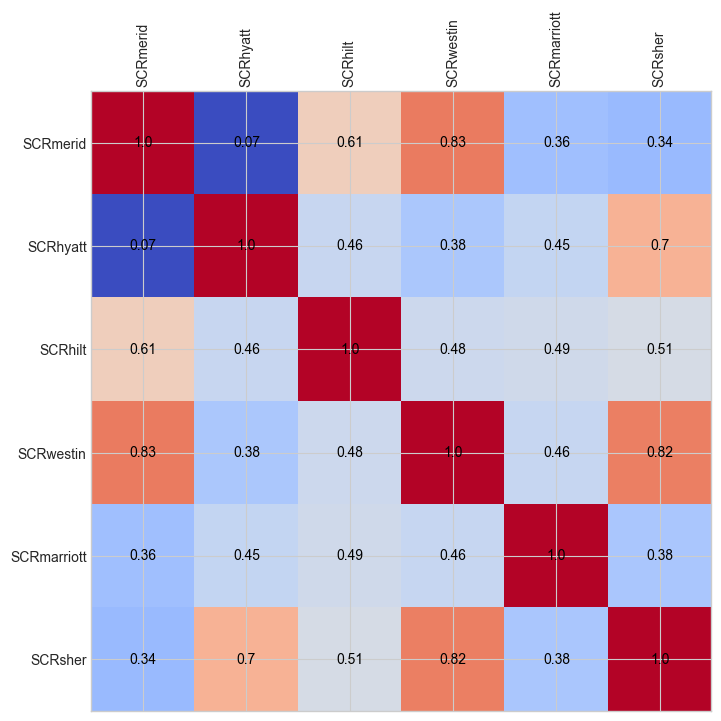

SCRhilt       0.29
SCRmarriott   0.26
SCRhyatt      0.22
SCRsher       0.18
SCRwestin     0.14
SCRmerid      0.05
dtype: float64

In [10]:
scr_cols = ['SCRmerid','SCRhyatt','SCRhilt','SCRwestin','SCRmarriott','SCRsher']
scr_summary = df[scr_cols].describe().T
display(scr_summary)
ajr_correlation_heatmap(df[scr_cols].corr(), fig_height=8)
df[scr_cols].mean().sort_values(ascending=False)


## 4. Penalty vs. preference intent
Meridien carries an average penalty score of 0.05 (meaning very few respondents say they would *refuse* the brand) but an average preference score of 3.97 with a median of 3.5. That split highlights headroom: the brand is rarely rejected outright yet isn't a habitual first choice.


,count,mean,std,min,25%,50%,75%,max
Meridienpen,361.00,0.05,0.22,0.00,0.00,0.00,0.00,1.00
Meridienpf,19.00,3.97,2.16,1.50,1.50,3.50,5.50,8.00
Hiltonpen,362.00,0.44,0.50,0.00,0.00,0.00,1.00,1.00
Hiltonpf,161.00,3.44,2.28,1.50,1.50,3.50,5.50,8.00
Hyattpen,363.00,0.27,0.44,0.00,0.00,0.00,1.00,1.00
Hyattpf,97.00,3.07,1.84,1.50,1.50,3.50,3.50,8.00


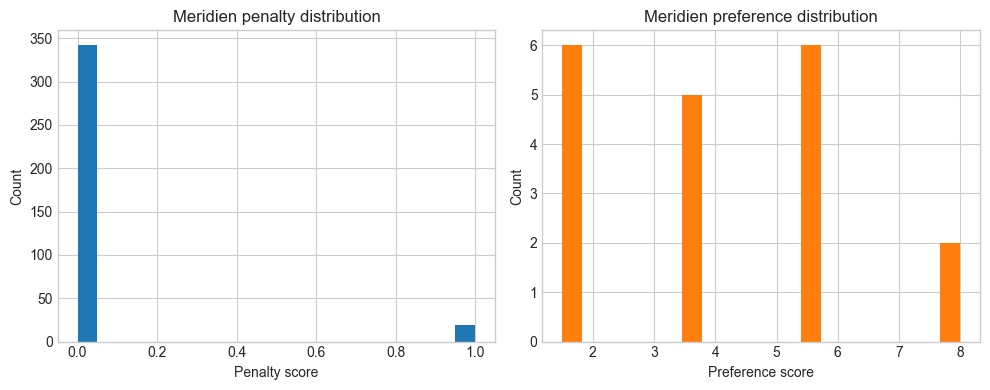

In [11]:
pen_cols = ['Meridienpen','Meridienpf','Hiltonpen','Hiltonpf','Hyattpen','Hyattpf']
pen_summary = df[pen_cols].describe().T
display(pen_summary)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
df['Meridienpen'].hist(ax=ax[0], bins=20)
ax[0].set_title('Meridien penalty distribution')
ax[0].set_xlabel('Penalty score')
ax[0].set_ylabel('Count')

df['Meridienpf'].dropna().hist(ax=ax[1], bins=20, color='tab:orange')
ax[1].set_title('Meridien preference distribution')
ax[1].set_xlabel('Preference score')
ax[1].set_ylabel('Count')

plt.tight_layout()
plt.show()


## 5. Segment lens (business vs. leisure)
Segmenting by the heavier trip purpose surfaces subtle SCR lifts for leisure-leaning guests:
- Balanced/No stays: avg total nights 3.9, Meridien nights 1.18, SCR 0.033
- Business leaning: avg total nights 22.1, Meridien nights 1.13, SCR 0.034
- Leisure leaning: avg total nights 10.6, Meridien nights 1.10, SCR 0.056
Leisure-heavy travelers report the highest Meridien SCR despite taking fewer total trips than business-leaning respondents, suggesting comfort and design cues might resonate more on leisure occasions.


In [12]:
seg_df = df[['totalnights','busnights','leisnights','Meridiennights','SCRmerid']].copy()
seg_df['segment'] = np.where(seg_df['busnights'] > seg_df['leisnights'], 'Business leaning',
                      np.where(seg_df['leisnights'] > seg_df['busnights'], 'Leisure leaning', 'Balanced/No stays'))
segment_summary = seg_df.groupby('segment')[['totalnights','Meridiennights','SCRmerid']].agg(['count','mean'])
segment_summary


totalnights       Meridiennights      SCRmerid     
                        count  mean          count mean    count mean
segment                                                              
Balanced/No stays          35  3.94             34 1.18        3 0.03
Business leaning           78 22.13             75 1.13        5 0.03
Leisure leaning           271 10.63            252 1.10       11 0.06

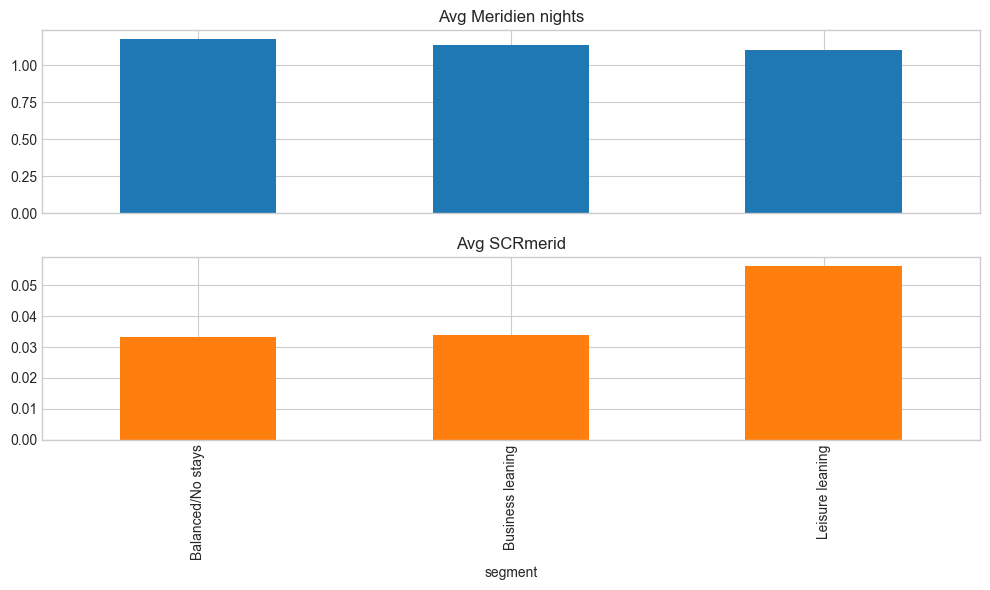

In [13]:
segment_means = seg_df.groupby('segment')[['Meridiennights','SCRmerid']].mean()
segment_means.plot(kind='bar', subplots=True, figsize=(10,6), legend=False, title=['Avg Meridien nights','Avg SCRmerid'])
plt.tight_layout()
plt.show()


## 6. Brand adjacency within Meridien guests
This quick pivot highlights average stay counts with other brands among respondents who logged at least one Meridien stay. It helps prioritize which loyalty databases or co-marketing opportunities overlap most.


In [14]:
mer_only = df[df['Meridiennights'] > 0]
adj_cols = ['Hyattnights','Hiltonnights','Westinnights','Marriottnights','Sheratonnights','Wyndhamnights','Courtyardnights']
adj_summary = mer_only[adj_cols].describe().T
adj_summary


,count,mean,std,min,25%,50%,75%,max
Hyattnights,357.00,1.46,0.90,1.00,1.00,1.00,2.00,5.00
Hiltonnights,355.00,1.85,1.20,1.00,1.00,1.00,2.00,5.00
Westinnights,356.00,1.30,0.83,1.00,1.00,1.00,1.00,5.00
Marriottnights,358.00,1.82,1.11,1.00,1.00,1.00,2.00,5.00
Sheratonnights,356.00,1.33,0.81,1.00,1.00,1.00,1.00,5.00
Wyndhamnights,360.00,1.29,0.73,1.00,1.00,1.00,1.00,5.00
Courtyardnights,357.00,1.52,0.92,1.00,1.00,1.00,2.00,5.00


## Key takeaways to revisit after reruns
- Engagement: Meridien guests almost always dabble in other premium Marriott and Hilton brands, so share-of-wallet plays should target the overlapping loyalty bases first.
- Experience drivers: Warmth/safety statements move SCR more than price/value ones, so future surveys or experiments should probe those feelings more deeply.
- Intent: Low penalty/high indifference means awareness or availability might be the gating factor rather than outright dislike.
- Segments: Leisure-heavy guests are the happiest—even with modest stay counts—so packages that emphasize leisure benefits could move the overall SCR faster than chasing road-warrior volume.
